[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

## Displacement estimation (in the signal domain)

\begin{equation}
\mathbf{s}(x, t) \approx \mathbf{s}(x+d, t+1)
\end{equation}
where $\mathbf{s}(x, t)$ represents the $x$-th sample of the $t$-th instance of the signal $\mathbf{s}$, and $d$ is a small displacement of the $x$-th sample in the $t+1$ instance.

We suppose a Signal Constancy Assumption
\begin{equation}
\mathbf{s}(x,t) \approx \mathbf{s}(x+d,t+1).
\end{equation}

Using a first order Taylor expansion for the RHS
\begin{equation}
\mathbf{s}(x,t) \approx \mathbf{s}(x,t) + \frac{\partial \mathbf{s}}{\partial x}d + \frac{\partial \mathbf{s}}{\partial t}.
\end{equation}

Defining $\mathbf{s}_x=\frac{\partial \mathbf{s}}{\partial x}$ and $\mathbf{s}_t=\frac{\partial \mathbf{s}}{\partial t}$ and assuming that the $\mathbf{s}$ should remains the same between instances, we get the 1D Optical Flow Constraint Equation
\begin{equation}
\mathbf{s}_x d+\mathbf{s}_t=0.
\end{equation}

Obviously, to solve $d$, $\mathbf{s}_x\neq 0$. Unfortunately, $\mathbf{s}_x$ can be zero in "flat" regions (for example, in a silence).

To address this situation, we can use a window of samples $W$ and solve $d$ using Least Squares. This generates an overdetermined system with $n$=size($W$) equations
\begin{equation}
\underbrace{
\begin{bmatrix}
\mathbf{s}_{x_1} \\
\mathbf{s}_{x_2} \\
\vdots \\
\mathbf{s}_{x_n}
\end{bmatrix}
}_{\mathbf{A}}
\underbrace{
\begin{bmatrix}
d
\end{bmatrix}
}_{\mathbf{d}}
=
\underbrace{
\begin{bmatrix}
-\mathbf{s}_{t_1} \\
-\mathbf{s}_{t_2} \\
\vdots \\
-\mathbf{s}_{t_n}
\end{bmatrix}
}_{\mathbf{b}}
\end{equation}

or what is equivalent
\begin{equation}
\mathbf{A}d=\mathbf{b}.
\end{equation}

This system can be solved using the least-squares normal equation
\begin{equation}
(\mathbf{A}^T\mathbf{A})d = \mathbf{A}^T\mathbf{b},
\end{equation}
where $\mathbf{A}^T\mathbf{A}=\sum_{i\in W}{\mathbf{s}_{x_i}}^2$, and $\mathbf{A}^T\mathbf{b}=\sum_{i\in W}-\mathbf{s}_{x_i}\mathbf{s}_{t_i}$. Finally,
\begin{equation}
d = \frac{\sum_{i\in W}-\mathbf{s}_{x_i}\mathbf{s}_{t_i}}{\sum_{i\in W}{\mathbf{s}_{x_i}}^2}.
\end{equation}

This is the motion estimation model used in Lucas-Kanade, which is a 1st-order (linear) model.

## Example

We'll start with two 1D signals. The second signal, $\mathbf{s}_2$, is a version of the first, $\mathbf{s}_1$, that has been shifted by $d=1$ and has had some minor noise added:
1. $\mathbf{s}_1=[2~4~6~8~10]^T$.
2. $\mathbf{s}_2=[0.1~1.8~4.1~6.3~7.9]^T$.

Now, remember:
1. $\mathbf{s}_{x_i}$ is the spatial derivative (gradient) at sample $i$.
2. $\mathbf{s}_{t_i}$ is the temporal derivative (change over time) at sample $i$.

Let's suppose that $W=\{x=2, x=3, x=4\}$. Now we need to compute both gradients, $\mathbf{s}_x=(\mathbf{s}_1(x+1) + \mathbf{s}_2(x-1))/2$ and $\mathbf{s}_t=\mathbf{s}_2(x) - \mathbf{s}_1(x)$. These calculus have been done in:

                       x = 2        x = 3          x = 4
         s_t =    1.8-4=-2.2   4.1-6=-1.9     6.3-8=-1.7
         s_x =  (6-2)/2)=2.0  (8-4)/2=2.0   (10-6)/2=2.0
    -s_x s_t =           4.4          3.8            3.4
       s_x^2 =           4.0          4.0            4.0

Therefore,
1. $\sum_{i\in W}-\mathbf{s}_{x_i}\mathbf{s}_{t_i}=11.6$, and
2. $\sum_{i\in W}{\mathbf{s}_{x_i}}^2=12.0$.

Finally, $d=(11.6/12.0)=0.967$.

## Displacement estimation (in a second-order (quadratic) polynomial expansion domain)
### Polynomial expansion

A window (section) of a 1D signal

Let 
\begin{equation}
a(x-x_0)^2+b(x-x_0)+c \approx f(x)
\end{equation}
the polynomial expansion of a signal $f(x)$ at point (index) $x=x_0$. To find $a$ (the curvature, second derivatie), $b$ (the slope, first derivative), and $c$ (local intensity), all of them scalar numbers, we formulate a least squares problem that minimizes
\begin{equation}
\text{min}_{a,b,c} \sum_{i\in W}w_i[a(x_i-x_0)^2+b(x_i-x_0)+c-f(x_i)]^2
\end{equation}
i.e., the MSE between the true value of the signal at the $i$-th sample inside of the window $W$ (being $x_0$ the center of the window), and the aproximation of the signal using its polynomial expansion at $x_0$, and $w_i=g(x_i-x_0)$ a Gaussian window of weights.
Depending on the size of $W$ we have that
\begin{equation}
\underbrace{
\begin{bmatrix}
(x_1-x_0)^2 & (x_1-x_0) & 1 \\
(x_2-x_0)^2 & (x_2-x_0) & 1 \\
\vdots & \vdots & \vdots \\
(x_N-x_0)^2 & (x_N-x_0) & 1 \\
\end{bmatrix}
}_{\text{call this }\mathbf{X}}
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
=
\begin{bmatrix}
f(x_1) \\
f(x_2) \\
\vdots \\
f(x_n)
\end{bmatrix}.
\end{equation}
Therefore, we minimize the error
\begin{equation}
E=||\mathbf{W}^{1/2}(\mathbf{X}\theta-\mathbf{f})||^2,
\end{equation}
where $\mathbf{W}=\text{diag}(\mathbf{w})$, and $\theta=[a~b~c]^T$.

The normal equiations of this system are
\begin{equation}
(\mathbf{X}^T\mathbf{W}\mathbf{X})\theta = \mathbf{X}^T\mathbf{W}\mathbf{f}
\end{equation}
and we solve
\begin{equation}
\theta = (\mathbf{X}^T\mathbf{W}\mathbf{X})^{-1}(\mathbf{X}^T\mathbf{W}\mathbf{f}).
\end{equation}

### Example
Let's take a simple discrete signal
$$
f=[1, 2, 4, 7, 11]
$$
corresponding to
$$
x=[0, 1, 2, 3, 4].
$$
We estimate the quadratic expansion centered at $x_0=2$, using Gaussian weights $\mathbf{w}_i=\exp(-(x_i-2)^2/2)$.

We fit
$$
f(x_i)\approx a(x_i-2)^2+b(x_i-2)+c
$$
using the code:

In [9]:
import numpy as np

# Data
x = np.arange(5)
f = np.array([1, 2, 4, 7, 11], dtype=float)
x0 = 2.0
dx = x - x0
w = np.exp(-dx**2 / 2)

# Design matrix
X = np.vstack([dx**2, dx, np.ones_like(dx)]).T
W = np.diag(w)

# Solve normal equations
theta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ f)
a, b, c = theta

print("x =", x)
print("f =", f)
print("a =", a, "b =", b, "c =", c)

x = [0 1 2 3 4]
f = [ 1.  2.  4.  7. 11.]
a = 0.4999999999999999 b = 2.5 c = 3.9999999999999996


So, locally arround $x_0=2$,
$$
\mathbf{f}(x=2)=4 \approx 0.49(x-2)^2 + 2.5(x-2)+3.99 = 0.49(2-2)^2 + 2.5(2-2)+3.99 = 3.99
$$.


### Motion estimation using the Farneback algorithm
Let's suppose now that
\begin{equation}
f_2(x) \approx f_1(x-d),
\end{equation}
where $f_2$ is a close version of $f_1$ after a displacement $d\in\mathbb{R}$. Let
\begin{equation}
\begin{array}{c}
f_1(x) = a_1(x-x_0)^2+b_1(x-x_0)+c_1\\
f_2(x) = a_2(x-x_0)^2+b_2(x-x_0)+c_2
\end{array}
\end{equation}
be the expansions of both signals at point $x_0$.

Expanding the shifted version of $f_1$ we get that
\begin{equation}
f_1(x-d) = a_i(x-x_0-d)^2+b_1(x-x_0-d)+c_1 = a_1(x-x_0)^2+(b_1-2a_1d)(x-x_0)+(a_1d^2-b_1d+c_1).
\end{equation}
Therefore, by comparison
1. $a_2=a_1$.
2. $b_2=b_1-2a_1d$.
3. $c_2=a_1d^2-b_1d+c_1$.

If now we solve for $d$, (using only the linear term relation)
\begin{equation}
b_2-b_1=-2a_1d,
\end{equation}
and hence, for each local region, we have that
\begin{equation}
d=\frac{b_1-b_2}{2a_1}.
\end{equation}

In [5]:
import numpy as np

# Define 1D signals
x = np.linspace(-2, 2, 9)
d_true = 0.5
f1 = 0.5*x**2 + x + 1
f2 = 0.5*(x - d_true)**2 + (x - d_true) + 1  # shifted version

# Gaussian weights for local fit
sigma = 1.0
def poly_fit(x, f, x0):
    dx = x - x0
    w = np.exp(-dx**2/(2*sigma**2))
    X = np.vstack([dx**2, dx, np.ones_like(dx)]).T
    W = np.diag(w)
    theta = np.linalg.inv(X.T@W@X)@(X.T@W@f)
    return theta  # [a,b,c]

# Fit at center x0 = 0
a1, b1, c1 = poly_fit(x, f1, 0)
a2, b2, c2 = poly_fit(x, f2, 0)

# Estimate displacement
d_est = -(b2 - b1) / (2*a1)

print("x=",x)
print("f1=", f1)
print("f2=", f2)
print(f"a1={a1:.4f} b1={b1:.4f} c1={c1:.4f}")
print(f"a2={a2:.4f} b2={b2:.4f} c2={c2:.4f}")
print("True displacement d_true =", d_true)
print("Estimated displacement d_est =", d_est)
print(f"Polynomial coefficients:\n a1={a1:.4f}, b1={b1:.4f}, b2={b2:.4f}")

x= [-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]
f1= [1.    0.625 0.5   0.625 1.    1.625 2.5   3.625 5.   ]
f2= [1.625 1.    0.625 0.5   0.625 1.    1.625 2.5   3.625]
a1=0.5000 b1=1.0000 c1=1.0000
a2=0.5000 b2=0.5000 c2=0.6250
True displacement d_true = 0.5
Estimated displacement d_est = 0.4999999999999998
Polynomial coefficients:
 a1=0.5000, b1=1.0000, b2=0.5000


### Dealing with the aperture problem
Assuming that $a_{2,i}\approx a_{1,i}\equiv a_i$ for all the samples of a neiborhood $\mathcal{N}$ around $x_0$, and Gaussian weights $w_i$, we form the weighted least-squares objective
\begin{equation}
E(d)=\sum_{i\in\mathcal{N}}w_i(b_{2,i}-b_{1,i}+2a_id)^2.
\end{equation}
We need to minimize $E(d)$ w.r.t. scalar $d$.

Differentiate and set to zero:
\begin{equation}
\frac{dE}{dd}=2\sumïw_i(b_{2,i}-b_{1,i}+2a_id)(2a_i)=0.
\end{equation}

Therefore,
\begin{equation}
d=\frac{\sum_i w_ia_i(b_{1,i}-b_{2,i})}{2\sum_i w_ia_i^2}
\end{equation}

Local quadratic (f1): a1=0.097, b1=0.300, c1=2.013
Local quadratic (f2): a2=%.3f, b2=%.3f, c2=%.3f
Estimated displacement around x=0: d = 1.002 (true=1.0)


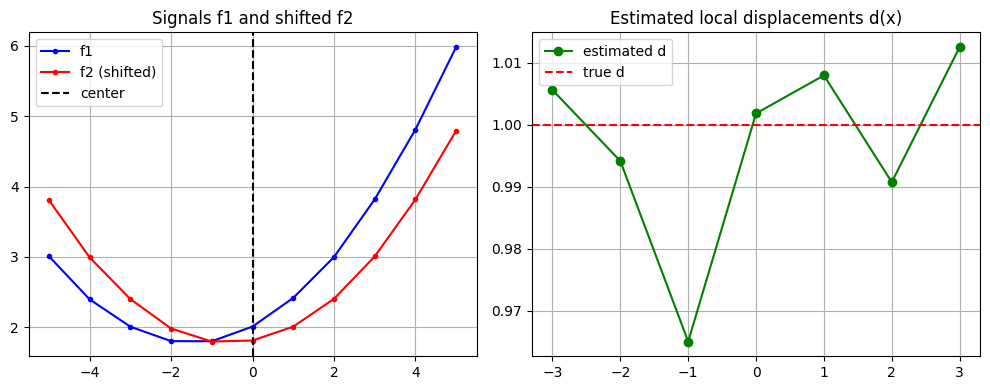

In [10]:
# Farneback 1D example without considering the Gaussian weights

import numpy as np
import matplotlib.pyplot as plt

# ---- Step 1: Create a synthetic 1D signal ----
x = np.arange(-5, 6)
true_d = 1.0  # true displacement

# original signal: smooth parabola
f1 = 0.1 * x**2 + 0.3 * x + 2 + 0.01*np.random.randn(len(x))

# shifted version (like next frame)
f2 = 0.1 * (x - true_d)**2 + 0.3 * (x - true_d) + 2 + 0.01*np.random.randn(len(x))

# ---- Step 2: Local quadratic fitting (polynomial expansion) ----
def fit_quadratic(xi, fi, x0):
    """
    Fit f(x) ≈ a*(x-x0)^2 + b*(x-x0) + c in least squares sense.
    """
    X = np.vstack([(xi - x0)**2, (xi - x0), np.ones_like(xi)]).T
    coeffs, *_ = np.linalg.lstsq(X, fi, rcond=None)
    return coeffs  # a, b, c

# Choose a center sample
i0 = 5  # center index
window = 2  # neighborhood radius
xi = x[i0-window:i0+window+1]
f1_local = f1[i0-window:i0+window+1]
f2_local = f2[i0-window:i0+window+1]

# Fit both signals locally
a1, b1, c1 = fit_quadratic(xi, f1_local, x[i0])
a2, b2, c2 = fit_quadratic(xi, f2_local, x[i0])

print("Local quadratic (f1): a1=%.3f, b1=%.3f, c1=%.3f" % (a1,b1,c1))
print("Local quadratic (f2): a2=%.3f, b2=%.3f, c2=%.3f")

# ---- Step 3: Estimate displacement d ----
# From Farnebäck’s derivation in 1D:
# a1 = a2  (approx)
# b2 ≈ b1 - 2*a1*d  ⇒  d ≈ (b1 - b2)/(2*a1)
d_est = (b1 - b2) / (2 * a1)
print(f"Estimated displacement around x={x[i0]}: d = {d_est:.3f} (true={true_d})")

# ---- Step 4: (Optional) Repeat for several neighborhoods ----
d_all = []
for i in range(window, len(x)-window):
    xi = x[i-window:i+window+1]
    a1, b1, c1 = fit_quadratic(xi, f1[i-window:i+window+1], x[i])
    a2, b2, c2 = fit_quadratic(xi, f2[i-window:i+window+1], x[i])
    d_all.append((b1 - b2) / (2 * a1))
d_all = np.array(d_all)

# ---- Step 5: Visualize ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Signals f1 and shifted f2")
plt.plot(x, f1, 'b.-', label='f1')
plt.plot(x, f2, 'r.-', label='f2 (shifted)')
plt.axvline(x[i0], color='k', ls='--', label='center')
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.title("Estimated local displacements d(x)")
plt.plot(x[window:-window], d_all, 'go-', label='estimated d')
plt.axhline(true_d, color='r', ls='--', label='true d')
plt.legend(); plt.grid()
plt.tight_layout()
plt.show()

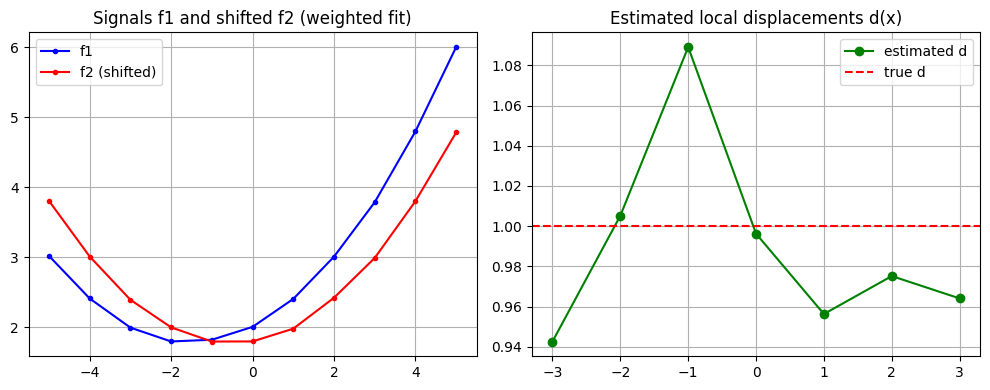

Average estimated displacement: 0.990 (true=1.0)


In [11]:
# Farneback 1D example considering the Gaussian weights in the expansion

import numpy as np
import matplotlib.pyplot as plt

# ---- Step 1: Create a synthetic 1D signal ----
x = np.arange(-5, 6)
true_d = 1.0  # true displacement

# Original signal (smooth curve)
f1 = 0.1 * x**2 + 0.3 * x + 2 + 0.01*np.random.randn(len(x))

# Shifted version (simulating motion)
f2 = 0.1 * (x - true_d)**2 + 0.3 * (x - true_d) + 2 + 0.01*np.random.randn(len(x))

# ---- Step 2: Weighted quadratic fitting ----
def fit_quadratic_weighted(xi, fi, x0, sigma=1.0):
    """
    Fit f(x) ≈ a*(x-x0)^2 + b*(x-x0) + c using weighted least squares
    with Gaussian weights centered at x0.
    """
    X = np.vstack([(xi - x0)**2, (xi - x0), np.ones_like(xi)]).T
    w = np.exp(-0.5 * ((xi - x0) / sigma)**2)
    W = np.diag(w)
    # Solve (X^T W X) theta = X^T W f
    XtWX = X.T @ W @ X
    XtWf = X.T @ W @ fi
    coeffs = np.linalg.solve(XtWX, XtWf)
    return coeffs, w

# ---- Step 3: Estimate local displacement using the weighted fits ----
window = 2
sigma = 1.0
d_estimates = []

for i in range(window, len(x)-window):
    xi = x[i-window:i+window+1]
    f1_local = f1[i-window:i+window+1]
    f2_local = f2[i-window:i+window+1]
    (a1, b1, c1), w = fit_quadratic_weighted(xi, f1_local, x[i], sigma)
    (a2, b2, c2), _ = fit_quadratic_weighted(xi, f2_local, x[i], sigma)
    # Farnebäck’s local displacement estimate:
    d = (b1 - b2) / (2 * a1)
    d_estimates.append(d)

# ---- Step 4: Plot results ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Signals f1 and shifted f2 (weighted fit)")
plt.plot(x, f1, 'b.-', label='f1')
plt.plot(x, f2, 'r.-', label='f2 (shifted)')
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.title("Estimated local displacements d(x)")
plt.plot(x[window:-window], d_estimates, 'go-', label='estimated d')
plt.axhline(true_d, color='r', ls='--', label='true d')
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()

print(f"Average estimated displacement: {np.mean(d_estimates):.3f} (true={true_d})")

OK, this last code consider the Gaussian weights for estimating the polynomial expansions. But Gaussian weights can also help during the computation of $d$. Can you extend the example?

# Testing 1D Farnebäck's optical flow estimator

In [ ]:
use_OpenCV = False
#use_OpenCV = True

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt update
    !apt install imagemagick
    !apt install cm-super
    !apt install dvipng
    !apt install bc
    !apt install texlive-latex-extra
    !apt install texlive-fonts-recommended

In [ ]:
try:
    import cv2
except:
    !pip install opencv-python
    import cv2

In [ ]:
try:
    import scipy
except:
    !pip install scipy
    import scipy

In [ ]:
try:
    import skimage
except:
    !pip install scikit-image
    import skimage

In [ ]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [ ]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" #for \text command
   
%matplotlib inline

In [ ]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [ ]:
try:
    from color_transforms import YCoCg as YUV
except:
    !pip install "color_transforms @ git+https://github.com/vicente-gonzalez-ruiz/color_transforms"
    from color_transforms import YCoCg as YUV

In [ ]:
try:
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image
except:
    !pip install "image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO"
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image

In [ ]:
try:
    from information_theory import information
    #from information_theory import distortion
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory import information
    #from information_theory import distortion

try:
    import motion_estimation
    #import optical_flow as motion
    #from motion_estimation import farneback
    #from motion_estimation import display
    #from motion_estimation import project
except:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
    #from motion_estimation import farneback
    import motion_estimation
    #import display
    #import prediction
    #from motion_estimation import optical_flow as motion
    #from motion_estimation import farneback as motion_estimator
    #from motion_estimation import display
    #from motion_estimation import predict

In [ ]:
if use_OpenCV:
    from motion_estimation._2D.farneback_OpenCV import OF_Estimation
    from motion_estimation._2D.project import project
else:
    from motion_estimation._1D.farneback_python import OF_Estimation
    from motion_estimation._1D.project import Projection

In [ ]:
from skimage import io as skimage_io

In [ ]:
img = skimage_io.imread("http://www.hpca.ual.es/~vruiz/images/barb.png")

In [ ]:
plt.imshow(img, cmap="gray")

## Testing effectiveness

### The flow between two lines that are identical should be zero.

In [ ]:
if use_OpenCV:
    w = 5
    reference_slice=img[301:301 + w]
    target_slice=img[300:300 + w]
else:
    reference_line = img[300].astype(np.float64) # This implementation of Farneback requires floats64 as inputs!!
    target_line = img[300].astype(np.float64)
    plt.plot(reference_line)
    plt.plot(target_line)

In [ ]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [ ]:
if use_OpenCV:
    estimator = OF_Estimation(logger, win_side=w, pyr_levels=3, verbosity=logging.WARNING)
    print(reference_slice.shape)
    initial_flow = np.zeros(shape=(reference_slice.shape[0], reference_slice.shape[1], 2), dtype=np.float32)
    flow = estimator.pyramid_get_flow(target=target_slice, reference=reference_slice, flow=initial_flow)
else:
    estimator = OF_Estimation(logger)
    initial_flow = np.zeros_like(reference_line, dtype=np.float32)
    flow = estimator.pyramid_get_flow(target=target_line, reference=reference_line, flow=initial_flow, N_poly=17, window_length=17, pyramid_levels=2)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(flow)

### We displace one pixel a central segment of the line

In [ ]:
if use_OpenCV:
    pass
else:
    reference_line = np.random.normal(loc=0, scale=10, size=len(img[300]))
    reference_line[256-32:256+32] = img[300,256-32:256+32]
    target_line = np.random.normal(loc=0, scale=10, size=len(img[300]))
    target_line[257-32:257+32] = img[300,256-32:256+32]
    plt.plot(reference_line)
    plt.plot(target_line)

In [ ]:
target_line.dtype

In [ ]:
if use_OpenCV:
    estimator = OF_Estimation(win_side=w, pyr_levels=3, verbosity=logging.WARNING)
    print(reference_slice.shape)
    initial_flow = np.zeros(shape=(reference_slice.shape[0], reference_slice.shape[1], 2), dtype=np.float32)
    flow = estimator.pyramid_get_flow(target=target_slice, reference=reference_slice, flow=initial_flow)
else:
    estimator = OF_Estimation()
    initial_flow = np.zeros_like(reference_line, dtype=np.float32)
    flow = estimator.pyramid_get_flow(
        target=target_line,
        reference=reference_line,
        flow=initial_flow,
        N_poly=17,
        window_length=17,
        pyramid_levels=0,
        iterations=3)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(flow)

In [ ]:
print(flow[256+32])

### Increase the flow (10 pixels)

In [ ]:
if use_OpenCV:
    pass
else:
    reference_line = np.random.normal(loc=0, scale=10, size=len(img[300]))
    reference_line[256-32:256+32] = img[300,256-32:256+32]
    target_line = np.random.normal(loc=0, scale=10, size=len(img[300]))
    target_line[266-32:266+32] = img[300,256-32:256+32]
    plt.plot(reference_line)
    plt.plot(target_line)

In [ ]:
if use_OpenCV:
    estimator = OF_Estimation(win_side=w, pyr_levels=3, verbosity=logging.WARNING)
    print(reference_slice.shape)
    initial_flow = np.zeros(shape=(reference_slice.shape[0], reference_slice.shape[1], 2), dtype=np.float32)
    flow = estimator.pyramid_get_flow(target=target_slice, reference=reference_slice, flow=initial_flow)
else:
    estimator = OF_Estimation()
    initial_flow = np.zeros_like(reference_line, dtype=np.float32)
    flow = estimator.pyramid_get_flow(
        target=target_line,
        reference=reference_line,
        flow=initial_flow,
        N_poly=17,
        window_length=17,
        pyramid_levels=0,
        iterations=3)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(flow)

In [ ]:
print(flow[256+32])

### Impact of N_poly

In [ ]:
flow = estimator.pyramid_get_flow(
    target=target_line,
    reference=reference_line,
    flow=initial_flow,
    N_poly=15,
    window_length=17,
    pyramid_levels=0,
    iterations=3)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(flow)

N_poly must be, at least for this example, 15.

### Impact of window_length

In [ ]:
flow = estimator.pyramid_get_flow(
    target=target_line,
    reference=reference_line,
    flow=initial_flow,
    N_poly=17,
    window_length=44,
    pyramid_levels=0,
    iterations=3)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(np.ones_like(target_line)*10)
    plt.plot(flow)

window_length >= 4.

### Testing pyramid_levels

In [ ]:
flow = estimator.pyramid_get_flow(
    target=target_line,
    reference=reference_line,
    flow=initial_flow,
    N_poly=17,
    window_length=17,
    pyramid_levels=4,
    iterations=3)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(np.ones_like(target_line)*10)
    plt.plot(flow)

If the displacements are not very large, the pyramid is not necessary.

### Checking num_iters

In [ ]:
flow = estimator.pyramid_get_flow(
    target=target_line,
    reference=reference_line,
    flow=initial_flow,
    N_poly=17,
    window_length=17,
    pyramid_levels=2,
    iterations=5)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(np.ones_like(target_line)*10)
    plt.plot(flow)

num_iters >= 2.

### Testing `project`

In [ ]:
projector = Projection()

In [ ]:
if use_OpenCV:
    projected_slice = project(reference_slice, flow)
    projected_line = projected_slice[(w + 1) >> 1, :]
    #compensated_line = np.roll(compensated_line, -w//2)
else:
    projected_line = projector.remap(reference_line, flow)

In [ ]:
if use_OpenCV:
    plt.plot(target_slice[(w + 1) >> 1, :])
    plt.plot(projected_line)
else:
    plt.plot(target_line)
    plt.plot(projected_line)

### Compensating two adjacent lines

In [ ]:
if use_OpenCV:
    w = 5
    reference_slice=img[301:301 + w]
    target_slice=img[300:300 + w]
else:
    reference_line = img[301].astype(np.float64)
    target_line = img[300].astype(np.float64)
    plt.plot(reference_line)
    plt.plot(target_line)

In [ ]:
if use_OpenCV:
    estimator = OF_Estimation(win_side=w, pyr_levels=3, verbosity=logging.WARNING)
    print(reference_slice.shape)
    initial_flow = np.zeros(shape=(reference_slice.shape[0], reference_slice.shape[1], 2), dtype=np.float32)
    flow = estimator.pyramid_get_flow(target=target_slice, reference=reference_slice, flow=initial_flow)
else:
    estimator = OF_Estimation()
    initial_flow = np.zeros_like(reference_line, dtype=np.float32)
    flow = estimator.pyramid_get_flow(target=target_line, reference=reference_line, flow=initial_flow, window_length=7)

In [ ]:
if use_OpenCV:
    from motion_estimation._2D.helpers import show_vectors
    show_vectors(flow)

In [ ]:
if use_OpenCV:
    plt.show(flow[..., 1])
else:
    plt.plot(flow)

In [ ]:
if use_OpenCV:
    projected_slice = project(reference_slice, flow)
    projected_line = projected_slice[(w + 1) >> 1, :]
    #compensated_line = np.roll(compensated_line, -w//2)
else:
    projected_line = projector.remap(reference_line, flow)

In [ ]:
if use_OpenCV:
    plt.plot(target_slice[(w + 1) >> 1, :])
    plt.plot(projected_line)
else:
    plt.plot(target_line)
    plt.plot(projected_line)

In [ ]:
if use_OpenCV:
    plt.plot(target_slice[(w + 1) >> 1, :])
    plt.plot(reference_slice[(w + 1) >> 1, :])
else:
    plt.plot(target_line)
    plt.plot(reference_line)

In [ ]:
if use_OpenCV:
    E0 = target_slice[(w + 1) >> 1, :].astype(np.float32) - reference_slice[(w + 1) >> 1, :]
    E1 = target_slice[(w + 1) >> 1, :].astype(np.float32) - projected_line
    plt.plot(E0, label="without OF")
    plt.plot(E1, label="with OF")
    plt.legend()
else:
    E0 = target_line.astype(np.float32) - reference_line
    E1 = target_line.astype(np.float32) - projected_line
    plt.plot(E0, label="without OF")
    plt.plot(E1, label="with OF")
    plt.legend()

In [ ]:
information.entropy(E0)

In [ ]:
information.entropy(E1)

In [ ]:
E0.dtype

### Using all the lines

In [ ]:
logger.setLevel(logging.WARNING)
if use_OpenCV:
    estimator = Estimator(win_side=w, pyr_levels=3, verbosity=logging.WARNING)
    E0 = np.zeros_like(img, dtype=np.int16)
    E1 = np.zeros_like(img, dtype=np.int16)
    P0 = np.zeros_like(img, dtype=np.uint8)
    P1 = np.zeros_like(img, dtype=np.uint8)
    for i in range(img.shape[0] - w):
        print(i, end=' ')
        R = img[i:i + w]
        T = img[i + 1: i + 1 + w]
        initial_flow = np.zeros(shape=(R.shape[0], R.shape[1], 2), dtype=np.float32)
        flow = estimator.pyramid_get_flow(target=T, reference=R, flow=initial_flow)
        projected_slice = project(R, flow)
        projected_line = projected_slice[(w + 1) >> 1, :]
        E0[i] = T[(w + 1) >> 1, :] - R[(w + 1) >> 1, :]
        E1[i] = T[(w + 1) >> 1, :] - projected_line
        P0[i] = R[(w + 1) >> 1, :]
        P1[i] = projected_line
else:
    estimator = OF_Estimation()
    from numpy.linalg import LinAlgError
    E0 = np.empty_like(img, dtype=np.int16)
    E1 = np.empty_like(img, dtype=np.int16)
    P0 = np.zeros_like(img, dtype=np.uint8)
    P1 = np.zeros_like(img, dtype=np.uint8)
    for i in range(img.shape[0] - 1):
        print(i, end=' ')
        R = img[i].astype(np.float64)
        P = img[i+1].astype(np.float64)
        try:
            initial_flow = np.zeros_like(R, dtype=np.float32)
            MVs = estimator.pyramid_get_flow(target=P, reference=R, flow=initial_flow, N_poly=17, window_length=17, pyramid_levels=2)
        except LinAlgError as e:
            print(f"Caught LinAlgError: {e}")
            MVs = np.zeros_like(R)
        hat_P = projector.remap(R, np.squeeze(MVs))
        E0[i] = P - R
        E1[i] = P - hat_P
        P0[i] = R
        P1[i] = hat_P

In [ ]:
plt.imshow(E0.astype(np.int8), cmap="gray")

In [ ]:
plt.imshow(E1.astype(np.int8), cmap="gray")

In [ ]:
plt.imshow(P0, cmap="gray")

In [ ]:
plt.imshow(P1, cmap="gray")

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
information.entropy(E0.flatten())

In [ ]:
information.entropy(E1.flatten())

In [ ]:
input()

In [ ]:
plt.plot(target_slice[(w + 1) >> 1, :])
plt.plot(compensated_line)

In [ ]:
plt.plot(target_slice[(win_side + 1) >> 1, :])
plt.plot(compensated_line)

In [ ]:
reference_slice.shape

In [ ]:
plt.imshow(reference_slice, cmap="gray")

In [ ]:
flow[(win_side+1)//2][:,0].shape

In [ ]:
plt.plot(flow[(win_side+1)//2][:,1])

In [ ]:
hat_P = project(R, np.squeeze(flow))
E1 = (P - hat_P).astype(np.int16)

In [ ]:
plt.plot(E1)

## Testing effectiveness

### Using only two lines

In [ ]:
R = img_Y[500]
P = img_Y[501]

In [ ]:
plt.plot(P)
plt.plot(R)

In [ ]:
estimator = Estimator(sigma_poly=4.0, sigma_flow=4.0, pyr_levels=2, verbosity=logging.WARNING)
initial_flow = np.zeros_like(R, dtype=np.float32)
flow = estimator.pyramid_get_flow(target=P, reference=R, flow=initial_flow)

In [ ]:
plt.plot(flow)

In [ ]:
hat_P = project(R, np.squeeze(flow))
E0 = P - R
E1 = (P - hat_P).astype(np.int16)

In [ ]:
plt.plot(E0)
plt.plot(E1)
plt.plot(E0, label="without OF")
plt.plot(E1, label="with OF")
plt.legend()
plt.plot()

In [ ]:
information.entropy(E0)

In [ ]:
information.entropy(E1)

### Using all the lines

In [ ]:
estimator = Estimator(sigma_poly=4.0, sigma_flow=4.0, pyr_levels=2, verbosity=logging.WARNING)
from numpy.linalg import LinAlgError
E0 = np.empty_like(img_Y, dtype=np.int16)
E1 = np.empty_like(img_Y, dtype=np.int16)
for i in range(img_Y.shape[0] - 1):
    print(i, end=' ')
    R = img_Y[i]
    P = img_Y[i+1]
    try:
        initial_flow = np.zeros_like(R, dtype=np.float32)
        MVs = estimator.pyramid_get_flow(target=P, reference=R, flow=initial_flow)
    except LinAlgError as e:
        print(f"Caught LinAlgError: {e}")
        MVs = np.zeros_like(R)
    hat_P = project(R, np.squeeze(MVs))
    E0[i] = P - R
    E1[i] = P - hat_P

In [ ]:
plt.imshow(E0, cmap="gray")

In [ ]:
plt.imshow(E1, cmap="gray")

In [ ]:
information.entropy(E0.flatten())

In [ ]:
information.entropy(E1.flatten())

In [ ]:
input()

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(MVs)
plt.show()

In [ ]:
hat_P = project(R_Y, np.squeeze(MVs))

In [ ]:
E0 = P_Y - R_Y

In [ ]:
E1 = (P_Y - hat_P).astype(np.int16)

In [ ]:
plt.figure()
plt.plot(R_Y)
plt.plot(hat_P)
plt.plot(E0, label="without OF")
plt.plot(E1, label="with OF")
plt.legend()
plt.show()

In [ ]:
E1.dtype

In [ ]:
information.entropy(E0)

In [ ]:
information.entropy(E1)

In [ ]:
plt.imshow(E0, cmap="gray")

In [ ]:
plt.imshow(E1, cmap="gray")

In [ ]:
input()

In [ ]:
c = np.ones_like(R_Y)
MVs = estimator.get_flow(np.roll(R_Y,10), R_Y, c, c, mu=0)

In [ ]:
MVs.shape

In [ ]:
plt.plot(MVs)

In [ ]:
plt.imshow(R)

In [ ]:
plt.imshow(np.swapaxes(R, 1, 0))

In [ ]:
R = np.swapaxes(R, 0, 1)
P = np.swapaxes(P, 0, 1)

In [ ]:
R.shape

In [ ]:
P.shape

In [ ]:
R_Y = YUV.from_RGB(R.astype(np.int16))[..., 0]
P_Y = YUV.from_RGB(P.astype(np.int16))[..., 0]

In [ ]:
print(R_Y, P_Y)

In [ ]:
print(R_Y.shape, P_Y.shape)

In [ ]:
#initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)
MVs = estimator.get_flow(target=P_Y, reference=R_Y, prev_flow=initial_MVs)

In [ ]:
print(np.max(MVs), np.min(MVs))

In [ ]:
R_Y.shape

In [ ]:
#gray_image.show(np.stack([R_Y, R_Y, R_Y, P_Y, P_Y, P_Y]), size=(30,10))
gray_image.show(np.stack([R_Y, P_Y], axis=0).reshape(6, 256), size=(30,10))


In [ ]:
MVs.shape

In [ ]:
motion_estimation.helpers.show_vectors(MVs)

In [ ]:
img = RGB_image.read(sequence + "015.png")[100:356, 100:456]
RGB_image.show(img,"")
print(img.dtype)

In [ ]:
#!export OPENCV_LOG_LEVEL=DEBUG

def filter_AAABBB(Y_img):
    # Iterate over rows
    total_flow_through_rows = []
    flow = np.zeros((3, Y_img.shape[1], 2), dtype=np.float32)
    for y in range(Y_img.shape[0]-1):
        prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #prev = np.stack([Y_img[y], Y_img[y+1], Y_img[y]])
        next = np.stack([Y_img[y+1], Y_img[y+1], Y_img[y+1]])
        #print(prev)
        if y==10:
            print(prev.shape, next.shape, flow.shape)
            print(np.max(prev), np.max(next))
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_rows.append(flow[1])
    # Iterate over columns
    total_flow_through_cols = []
    flow = np.zeros((3, Y_img.shape[0], 2), dtype=np.float32)
    for x in range(Y_img.shape[1]-1):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, x+1], Y_img[:, x+1], Y_img[:, x+1]])
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_cols.append(flow[1])
    return np.stack(total_flow_through_rows), np.stack(total_flow_through_cols)

N = 5

def filter_AAABBB(Y_img):
    print(np.average(Y_img))
    extended_img = np.zeros(shape=(Y_img.shape[0]+N, Y_img.shape[1]+N), dtype=Y_img.dtype)
    extended_img[N//2:Y_img.shape[0]+N//2, N//2:Y_img.shape[1]+N//2] = Y_img[:, :]
    # Iterate over rows
    total_flow_rows_pass = []
    prev_flow = np.zeros((N, Y_img.shape[1], 2), dtype=np.float32)
    N_rows = Y_img.shape[0]
    c = 0
    for y in range(N_rows):
        #prev = np.stack([Y_img[y], Y_img[(y+1)%N_rows], Y_img[(y+2)%N_rows]])
        #next = np.stack([Y_img[(y+3)%N_rows], Y_img[(y+4)%N_rows], Y_img[(y+5)%N_rows]])
        #prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #next = np.stack([Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows]])
        prev = extended_img[y:y+N]
        #next = np.roll(prev, 1, axis=1)
        next = extended_img[y+1:y+1+N]
        assert prev.shape==next.shape, f"{c} {prev.shape} {next.shape}"
        #print(prev)
        #print(next)
        #print(prev)
        #if y==10:
        #    print(prev.shape, next.shape, flow[1].shape)
        #    print(np.max(prev), np.max(next))
        #    print(np.max(Y_img[y]), np.max(Y_img))
        #    print(prev, next)
        #flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=prev_flow, wside=N)
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #prev_flow = flow.copy()
        #flow = np.random.rand(flow.size).reshape(flow.shape).astype(np.float32)
        print(c, np.max(np.abs(flow[N>>1][..., 0])), np.max(np.abs(flow[N>>1][..., 1])))
        #print(flow.shape)
        #print(np.unravel_index(np.argmax(abs(flow[1])), flow[1].shape), np.max(abs(flow[1])), end=' ')
        total_flow_rows_pass.append(flow[N>>1][..., 0])
        #print(flow[0], total_flow_rows_pass)
        max = 0
        for i in total_flow_rows_pass:
            _max = np.max(np.abs(i))
            if _max > max:
                max = _max
        #print("max=", max)
        c += 1
    #print(len(total_flow_rows_pass))
    #print(total_flow_rows_pass)
    #for i in total_flow_rows_pass:
    #    if np.max(np.abs(i)) != 0.0:
    #        print("!", end='')
    #total_flow_rows_pass = np.array(total_flow_rows_pass).reshape((Y_img.shape[0], Y_img.shape[1]))
    total_flow_rows_pass = np.stack(total_flow_rows_pass)
    print("max=", np.max(np.abs(total_flow_rows_pass)))
    # Iterate over columns
    total_flow_cols_pass = []
    flow = np.zeros((N, Y_img.shape[0], 2), dtype=np.float32)
    N_cols = Y_img.shape[1]
    for x in range(N_cols):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols]])
        #prev = np.stack([Y_img[:, x], Y_img[:, (x+1)%N_cols], Y_img[:, (x+2)%N_cols]])
        #next = np.stack([Y_img[:, (x+3)%N_cols], Y_img[:, (x+4)%N_cols], Y_img[:, (x+4)%N_cols]])
        #flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_cols_pass.append(flow[N>>1][..., 1])
    #total_flow_cols_pass = np.stack(total_flow_cols_pass)
    total_flow_cols_pass = np.array(total_flow_cols_pass).reshape(Y_img.shape)
    return total_flow_rows_pass, total_flow_cols_pass

def get_fields(Y_img):
    extended_img = np.zeros(shape=(Y_img.shape[0]+N, Y_img.shape[1]+N), dtype=Y_img.dtype)
    extended_img[N//2:Y_img.shape[0]+N//2, N//2:Y_img.shape[1]+N//2] = Y_img[:, :]
    # Iterate over rows
    total_flow_rows_pass = []
    prev_flow = np.zeros((N, Y_img.shape[1], 2), dtype=np.float32)
    N_rows = Y_img.shape[0]
    c = 0
    for y in range(N_rows):
        prev = extended_img[y:y+N]
        #next = np.roll(prev, 1, axis=1)
        next = extended_img[y+1:y+1+N]
        #prev_flow = flow.copy()
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #flow = np.random.rand(flow.size).reshape(flow.shape).astype(np.float32)
        #print(c, np.max(np.abs(flow[N>>1][..., 0])), np.max(np.abs(flow[N>>1][..., 1])))
        #print(np.unravel_index(np.argmax(abs(flow[1])), flow[1].shape), np.max(abs(flow[1])), end=' ')
        #total_flow_rows_pass.append(flow[N>>1][..., 0])
        total_flow_rows_pass.append(flow[(N>>1) + 1, :, 0])
        c += 1

    #total_flow_rows_pass = np.array(total_flow_rows_pass).reshape((Y_img.shape[0], Y_img.shape[1]))
    total_flow_rows_pass = np.stack(total_flow_rows_pass)
    # Iterate over columns
    total_flow_cols_pass = []
    flow = np.zeros((Y_img.shape[0], N, 2), dtype=np.float32)
    N_cols = Y_img.shape[1]
    for x in range(N_cols):
        prev = extended_img[..., x:x+N]
        next = extended_img[..., x+1:x+1+N]
        #print(prev.shape, next.shape)
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #print(flow[..., N>>1, 1].shape)
        total_flow_cols_pass.append(flow[..., (N>>1) + 1, 1])
    total_flow_cols_pass = np.stack(total_flow_cols_pass, axis=1)
    #total_flow_cols_pass = np.array(total_flow_cols_pass).reshape(Y_img.shape)
    return total_flow_rows_pass, total_flow_cols_pass

In [ ]:
Y_img = YUV.from_RGB(img.astype(np.int16))[..., 0]
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:105,100:107])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:125])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:225,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:625,100:625])
#flow_rows, flow_cols = filter_AAABBB(Y_img[10:758,10:1270])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:668,100:1180])
#flow_rows, flow_cols = filter_AAABBB(Y_img[40:740,40:1170])
#flow_rows, flow_cols = filter_AAABBB(Y_img)
flow_rows, flow_cols = get_fields(Y_img)

In [ ]:
768*1280

In [ ]:
flow_rows.shape

In [ ]:
flow_cols.shape

In [ ]:
np.max(flow_rows)

In [ ]:
768*1280

In [ ]:
np.min(flow_rows)

In [ ]:
matplotlib.pyplot.imshow(X=flow_rows, cmap="gray")

In [ ]:
matplotlib.pyplot.imshow(X=flow_cols, cmap="gray")

In [ ]:
gray_image.show(flow_rows*255,"")

In [ ]:
gray_image.show(flow_cols*255,"")

In [ ]:
def get_flow(prev, next, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=prev_flow,
                                        pyr_scale=0.5, levels=l, winsize=w,
                                        iterations=3, poly_n=5, poly_sigma=1.2,
                                        flags=0)
    return flow[(N>>1) + 1, :, 0]

In [ ]:
def vertical_filtering(img, kernel):
    KS = kernel.size
    KS2 = KS//2
    extended_img = np.zeros(shape=(img.shape[0] + KS, img.shape[1] + KS), dtype=img.dtype)
    extended_img[KS2:img.shape[0] + KS2, KS2:img.shape[1] + KS2] = img[:, :]
    N_rows = img.shape[0]
    tmp_slice = np.zeros(shape=(img.shape[1]))
    for y in range(N_rows):
        for i in range(KS2 - 1, -1, -1):
            prev = extended_img[y:y + w]
            next = extended_img[y + 1:y + 1 + w]
            flow = get_flow(prev, next, l, w, None)

# 2D Gaussian filtering

In [ ]:
import time

def vertical_gaussian_filtering(img, kernel, mean):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0] + KL, img.shape[1]))
    extended_img[KL2:img.shape[0] + KL2, :] = img[:, :]
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(N_cols, dtype=np.float32)
        for i in range(KL):
            horizontal_line += extended_img[y + i, :] * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def horizontal_gaussian_filtering(img, kernel, mean):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0], img.shape[1] + KL))
    extended_img[:, KL2:img.shape[1] + KL2] = img[:, :]
    #filtered_img = []
    filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    vertical_line = np.empty(N_rows, dtype=np.float32)
    for x in range(N_cols):
        #vertical_line = np.zeros(N_rows, dtype=np.float32)
        vertical_line.fill(0)
        for i in range(KL):
            vertical_line += extended_img[:, x + i] * kernel[i]
        #filtered_img.append(vertical_line)
        filtered_img[:, x] = vertical_line[:]
    #filtered_img = np.stack(filtered_img, axis=1)
    return filtered_img

def gaussian_filtering(img, kernel):
    mean = np.average(img)
    t0 = time.perf_counter()
    filtered_img_Y = vertical_gaussian_filtering(img, kernel, mean)
    t1 = time.perf_counter()
    print(t1 - t0)
    filtered_img_YX = horizontal_gaussian_filtering(filtered_img_Y, kernel, mean)
    t2 = time.perf_counter()
    print(t2 - t1)
    return filtered_img_YX

def gaussian_kernel(sigma):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

def color_gaussian_filtering(img, kernel):
    filtered_img_R = gaussian_filtering(img[..., 0], kernel)
    filtered_img_G = gaussian_filtering(img[..., 1], kernel)
    filtered_img_B = gaussian_filtering(img[..., 2], kernel)
    return np.stack([filtered_img_R, filtered_img_G, filtered_img_B], axis=2)

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(filtered_img.astype(np.uint8),"")

# 2D OF-driven Gaussian filtering

In [ ]:

def horizontal_OF_gaussian_filtering(img, kernel, mean=128, l=3 , w=5):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0], img.shape[1] + KL + 2*w, img.shape[2]))
    extended_img[:, KL2 + w:img.shape[1] + KL2 + w] = img[:, :]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for x in range(N_cols):
        vertical_line = np.zeros(N_rows, dtype=np.float32)
        for i in range(KL):
            reference = extended_img[:, x + i    :x + i     + w] 
            target    = extended_img[:, x + i + 1:x + i + 1 + w]
            flow = get_flow(target, reference, l, w, None)
            #OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_slice = warp_slice(target, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1]
            vertical_line += OF_compensated_line * kernel[i]

        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    return filtered_img

def vertical_OF_gaussian_filtering(Y_img, img, kernel, mean, l=3 , w=5):
    KL = kernel.size
    KL2 = KL//2
    extended_Y_img = np.full(fill_value=mean[0], shape=(Y_img.shape[0] + KL + 2*w, Y_img.shape[1]))
    extended_Y_img[KL2 + w:Y_img.shape[0] + KL2 + w, :] = Y_img[:, :]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    flow_rows = []
    for y in range(N_rows):
        horizontal_line = np.zeros(N_cols, dtype=np.float32)
        for i in range(KL):
            #reference = extended_img[y + i    :y + i     + w, :] 
            #target    = extended_img[y + i + 1:y + i + 1 + w, :]
            reference = extended_img[y    :y     + w, :] 
            target    = extended_img[y + i:y + i + w, :]
            #assert reference.shape == target.shape, f"{reference.shape} {target.shape}"
            flow = get_flow(target, reference, l, w, None)
            #flow = get_flow(reference, target, l, w, None)
            OF_compensated_slice = warp_slice(reference, flow)
            #OF_compensated_slice = warp_slice(target, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :]
            horizontal_line += OF_compensated_line * kernel[i]
            if i==0: #i==(KL-1):
                flow_rows.append(flow[(w + 1)>>1, :, 0])
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)
    flow_rows = np.stack(flow_rows)
    return filtered_img, flow_rows


def OF_gaussian_filtering(Y_img, img, kernel, l=3, w=5):
    mean = [np.average(img)[..., 0], np.average(img)[..., 1], np.average(img)[..., 2]]
    t0 = time.perf_counter()
    filtered_img_y, _ = vertical_OF_gaussian_filtering(Y_img, img, kernel, mean, l , w)
    t1 = time.perf_counter()
    print(t1 - t0)
    filtered_img_yx = horizontal_OF_gaussian_filtering(Y_img, filtered_img_y, kernel, mean, l , w)
    #filtered_img_YX = horizontal_OF_gaussian_filtering(img, kernel, mean, l , w)
    t2 = time.perf_counter()
    print(t2 - t1)
    return filtered_img_yx, _

def color_OF_gaussian_filtering(img, kernel, l=3, w=5):
    Y_img = YUV.from_RGB(img.astype(np.int16))[..., 0]
    filtered_img,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #filtered_img_G,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #filtered_img_B,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #return np.stack([filtered_img_R, filtered_img_G, filtered_img_B], axis=2), flow_rows
    return filtered_img

In [ ]:
def warp_slice(reference, flow):
    height, width = flow.shape[:2]
    map_x = np.tile(np.arange(width), (height, 1))
    map_y = np.swapaxes(np.tile(np.arange(height), (width, 1)), 0, 1)
    map_xy = (flow + np.dstack((map_x, map_y))).astype('float32')
    warped_slice = cv2.remap(reference, map_xy, None,
                             interpolation=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
    return warped_slice

def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
    return flow

def OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    
    # Filtering along the vertical direction
    filtered_img = []
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y:y + w, :]
        for i in range(KL2):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference_slice = img[y:y + w, :]
            OF_compensated_vertical_slice = warp_slice(reference_slice, flow)
            OF_compensated_vertical_line = OF_compensated_vertical_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        horizontal_line += img[y, :, :] * kernel[KL2]
        for i in range(KL2 + 1, KL):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference_slice = img[y:y + w, :]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)    
    filtered_img = np.stack(filtered_img, axis=0)
    
    img = filtered_img
    
    # Horizontal direction
    filtered_img = []
    for x in range(N_cols):
        vertical_line = np.zeros(shape=(N_rows, img.shape[2]), dtype=np.float32)
        reference_slice_Y = Y[:, x:x + w] 
        for i in range(KL2):
            target_slice_Y = Y[:, x + i:x + i + w]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference = img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1, :]
            vertical_line += OF_compensated_line * kernel[i]
        vertical_line += img[:, x, :] * kernel[KL2]
        for i in range(KL2 + 1, KL):
            target_slice_Y = Y[:, x + i:x + i + w]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference = img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1, :]
            vertical_line += OF_compensated_line * kernel[i]
        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    
    return filtered_img

def _OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    #Y_mean = np.average(Y_img)[..., 0]
    # Signal extension?
    #extended_Y_img = np.full(fill_value=mean[0], shape=(Y_img.shape[0] + KL + 2*w, Y_img.shape[1] + KL + 2*w))
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2 + w:Y.shape[0] + KL2 + w2, KL2 + w:Y.shape[1] + KL2 + w2] = Y[...]
    #extended_img = np.full(fill_value=mean[0], shape=(img.shape[0] + KL + 2*w, img.shape[1] + KL + 2*w, img.shape[3]))
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + KL + 2*w, img.shape[0] + KL + 2*w))
    extended_img[KL2 + w:img.shape[0] + KL2 + w2, KL2 + w:img.shape[1] + KL2 + w2] = img[...]
    print(extended_img.shape)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    
    # Vertical
    filtered_img = []
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        for i in range(0, KL2):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
        for i in range(KL):
            # For i=0, the flow==0, and this case can be out of the loop
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            flow = get_flow(target_Y, reference_Y, l, w, None)
            #reference = extended_img[y:y + w, :]
            reference = extended_img[y:y + w, :]
            OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            print(reference.shape, OF_compensated_slice.shape, OF_compensated_line.shape)
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)
    
    extended_img[KL2 + w:img.shape[0] + KL2 + w, KL2 + w:img.shape[1] + KL2 + w] = filtered_img[...]
    
    # Horizontal
    filtered_img = []
    for x in range(N_cols):
        vertical_line = np.zeros(N_rows, dtype=np.float32)
        for i in range(KL):
            reference_Y = extended_Y[:, x    :x +   + w] 
            target_Y    = extended_Y[:, x + i:x + i + w]
            flow = get_flow(target_Y, reference_Y, l, w, None)
            reference = extended_img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1]
            vertical_line += OF_compensated_line * kernel[i]
        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    
    return filtered_img


In [ ]:
def vertical_OF_gaussian_filtering(img, kernel, l =3, w=5):
    '''This method '''
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    #extended_img = np.full(fill_value=128, shape=(img.shape[0] + KL, img.shape[1], img.shape[2]))
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    print(extended_img.shape)
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y:y + w, :]
        reference_slice = img[y:y + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, KL2+w2+1:-KL2-w2-1, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

In [ ]:
def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=0.5,
                                            flags=0)
    return flow

def vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    #extended_img = np.full(fill_value=128, shape=(img.shape[0] + KL, img.shape[1], img.shape[2]))
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    #print(extended_img.shape)
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows - KL - w):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        #reference_slice_Y = extended_Y[y:y + w, :]
        target_slice_Y = Y[y + KL2:y + KL2 + w, :]
        target_slice = img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            #horizontal_line += img[(y + i) % img.shape[0], :] * kernel[i]
            reference_slice_Y = Y[y + i:y + i + w, :]
            reference_slice = img[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            #flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            #flow = get_flow(reference_slice_Y, reference_slice_Y, l, w, None)
            #flow = np.zeros((reference_slice_Y.shape[0], reference_slice_Y.shape[1], 2), dtype=np.float32)
            #print(flow.shape, reference_slice.shape, reference_slice.dtype)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            #OF_compensated_slice = warp_slice(target_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            #OF_compensated_line = OF_compensated_slice[0, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def _vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols  + KL + w, img.shape[2]), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        target_slice = extended_img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            #horizontal_line += img[(y + i) % img.shape[0], :] * kernel[i]
            reference_slice_Y = extended_Y[y + i:y + i + w, :]
            reference_slice = extended_img[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            #flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            #flow = get_flow(reference_slice_Y, reference_slice_Y, l, w, None)
            #flow = np.zeros((reference_slice_Y.shape[0], reference_slice_Y.shape[1], 2), dtype=np.float32)
            print(flow.shape, reference_slice.shape)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            #OF_compensated_slice = warp_slice(target_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            #OF_compensated_line = OF_compensated_slice[0, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    print(f"KL={KL} l={l} w={w}")
    
    # Opción 0: Los márgenes son 128
    #extended_img = np.full(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), fill_value=128, dtype=np.uint8)
    
    # Opción 1: Usando padding (no terminó de funcionar)
    #extended_img = np.empty(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), dtype=np.uint8)
    #extended_img[..., 0] = np.pad(array=img[..., 0],
    #                              pad_width=(((KL + w)//2, (KL + w)//2), ((w + 1)//2, (w + 1)//2)),
    #                              mode="constant")
    #extended_img[..., 1] = np.pad(array=img[..., 1], pad_width=(KL2 + w2, w2), mode="constant")
    #extended_img[..., 2] = np.pad(array=img[..., 2], pad_width=(KL2 + w2, w2), mode="constant")
    
    # Opción 2: Los márgenes son la propia imagen, ampliada
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + w, img.shape[0] + KL + w))
    print(extended_img.shape)
    extended_img[KL2 + w2:img.shape[0] + KL2 + w2, w2:img.shape[1] + w2] = img[...]
    extended_Y = YUV.from_RGB(extended_img.astype(np.int16))[..., 0]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols + w, img.shape[2]), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        target_slice = extended_img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            reference_slice_Y = extended_Y[y + i:y + i + w, :]
            reference_slice = extended_img[y + i:y + i + w, :]
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)[0:img.shape[0], 0:img.shape[1], :]
    return filtered_img

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = RGB_image.read(sequence + "003.png")

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/lena.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
RGB_image.show((img - OF_filtered_img + 128).astype(np.uint8),"")
RGB_image.show((img - filtered_img + 128).astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/Homer.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/sandiego.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/rana.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/calar_alto.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://cloudinary-res.cloudinary.com/image/upload/c_fill,w_300/butterfly.jpg"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
RGB_image.show((img - OF_filtered_img + 128).astype(np.uint8),"")
RGB_image.show((img - filtered_img + 128).astype(np.uint8),"")

In [ ]:
def gray_vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    
    # Opción 0: Los márgenes son 128
    #extended_img = np.full(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), fill_value=128, dtype=np.uint8)
    
    # Opción 1: Usando padding (no terminó de funcionar)
    #extended_img = np.empty(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), dtype=np.uint8)
    #extended_img[..., 0] = np.pad(array=img[..., 0],
    #                              pad_width=(((KL + w)//2, (KL + w)//2), ((w + 1)//2, (w + 1)//2)),
    #                              mode="constant")
    #extended_img[..., 1] = np.pad(array=img[..., 1], pad_width=(KL2 + w2, w2), mode="constant")
    #extended_img[..., 2] = np.pad(array=img[..., 2], pad_width=(KL2 + w2, w2), mode="constant")
    
    # Opción 2: Los márgenes son la propia imagen, ampliada
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + w, img.shape[0] + KL + w))
    print(extended_img.shape)
    extended_img[KL2 + w2:img.shape[0] + KL2 + w2, w2:img.shape[1] + w2] = img[...]
    extended_Y = extended_img
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols + w), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w]
        target_slice = extended_img[y + KL2:y + KL2 + w]
        for i in range(KL):
            reference_slice_Y = extended_Y[y + i:y + i + w]
            reference_slice = extended_img[y + i:y + i + w]
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)[0:img.shape[0], 0:img.shape[1]]
    return filtered_img

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/barb.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/cameraman.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://boofcv.org/images/6/66/Kodim17_noisy.jpg"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)[..., 0]
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = OF_filtered_img
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))

In [ ]:
gray_image.show(OF_filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://people.math.sc.edu/Burkardt/c_src/image_denoise/balloons_noisy.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=2.5,
                                            flags=0)
    return flow

kernel = gaussian_kernel(4.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=33)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=33)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = OF_filtered_img
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=33)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=33)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))

In [ ]:
RGB_image.show(OF_filtered_img.astype(np.uint8),"")

In [ ]:
fn = "TwoPhoton_BPAE_B_1.png"
img = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.title("original")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
plt.imshow(filtered_img.astype(np.uint8), cmap='gray')
plt.title(f"Gaussian Filtering")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
plt.imshow(OF_filtered_img.astype(np.uint8), cmap='gray')
plt.title(rf"OF Gaussian Filtering")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
input()

In [ ]:
matplotlib.pyplot.imshow(X=flow_rows2, cmap="gray")

In [ ]:
img.shape

In [ ]:
img[3:img.shape[0],:,:].shape

In [ ]:
img[3:img.shape[0]+1,:,:].shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# create an array of vectors
vectors = np.array([[1, 2], [2, 1], [0, 3], [3, 0]])

# plot the vectors
origin = [0], [0]  # origin point
plt.quiver(*origin, vectors[:, 0], vectors[:, 1], color=['r', 'b', 'g', 'y'], scale=10)
plt.axis('equal')   # set the aspect ratio to 'equal'
plt.show()

## Working with 1-d lines

In [ ]:
R_Y_line = R_Y[..., 1]
P_Y_line = P_Y[..., 2]

In [ ]:
print(R_Y_line.shape,P_Y_line.shape)

In [ ]:
R = np.stack([np.roll(R_Y_line,-1), R_Y_line, np.roll(R_Y_line,1)])
P = np.stack([np.roll(P_Y_line,-1), P_Y_line, np.roll(P_Y_line,1)])

In [ ]:
print(R.shape, P.shape)

In [ ]:
for i in range(10):
    print(R[0, i], R[1, i])

In [ ]:
for i in range(10):
    print(P[0, i], P[1, i])

In [ ]:
for i in range(10):
    print(R[0, i], P[1, i])

In [ ]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs, wside=3)

In [ ]:
#print(np.max(MVs[1]), np.min(MVs[1]), np.argmax(MVs[1]), MVs[np.argmax(MVs[1])])
print(np.max(MVs[1]), np.min(MVs[1]), len(MVs[1]), np.argmax(MVs[1]))

In [ ]:
for i in range(P.shape[1]):
    print(i, R[1, i], P[1, i], MVs[1, i])

In [ ]:
line = np.arange(4).astype(np.int16)
block = np.stack([line, line, line, line])
print(block)
#block = np.arange(16).astype(np.int16).reshape(4, 4)
c = np.ones_like(block)
A, B, C = poly_exp(block, c, sigma=1.0)

## Farnebäck basis transform
Farnebäck's algorithm does not compare pixels, but polinomial coefficients (each pixel generates 6 coefficients) using Polinomial Expansion.

### No motion

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the X direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the Y direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Contant motion in both directions (at the same time)

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the Y direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the X direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

## Farneback 1D

In [ ]:
def poly_exp_1D(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 1D signal.
    
    $f ~ x^T A x + B^T x + C$
    
    If f[i] and c[i] are the signal value and certainty of pixel i then
    A[i] is a 1x1 array representing the quadratic term of the polynomial, B[i]
    is a 1-element array representing the linear term, and C[i] is a scalar
    representing the constant term.
    
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Kernel applicability
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", x)
    a = np.exp(-(x**2) / (2 * sigma**2))
    print("a =", a)

    # b: calculate b from the paper.
    b = np.stack([np.ones(a.shape), x, x**2], axis=-1)
    print("b =", b)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("f =", f)
    print("c =", c)
    print("cf =", cf)
    

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [b.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [b.shape[-1]])

    #G = np.empty(list(f.shape))
    #v = np.empty(list(f.shape))
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply cross-correlation

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, b) # a[i]*b[i,j] -> ab[i,j]
    abb = np.einsum("ij,ik->ijk", ab, b) # ab[i,j]*b[i,k] -> abb[i,j,k]
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(b.shape[-1]):
        for j in range(b.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )
    #for j in range(b.shape[-1]):
    #    G[..., j] = scipy.ndimage.correlate1d(
    #        c, abb[..., j], axis=0, mode="constant", cval=0
    #    )
    print("G =", G)
    print("v =", v)

    #v = scipy.ndimage.correlate1d(
    #    cf, ab, axis=0, mode="constant", cval=0
    #)

    # Solve r for each pixel
    r = np.linalg.solve(G, v)
    print("r =", r)

    # Quadratic term
    #A = np.empty(list(f.shape))
    A = np.empty(list(f.shape)  + [1])
    A[..., 0] = r[..., 2]
    print("A =", A)

    # Linear term
    #B = np.empty(list(f.shape))
    B = np.empty(list(f.shape) + [1])
    B[..., 0] = r[..., 1]
    print("B =", B)

    # constant term
    C = r[..., 0]
    print("C =", C)

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)
    return A, B, C


In [ ]:
line = np.arange(4).astype(np.int16)
c = np.ones_like(line)
A, B, C = poly_exp_1D(line, c, sigma=1.0)

In [ ]:
def flow_iterative_1D(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the lines
    A1, B1, C1 = poly_exp_1D(f1, c1, sigma)
    A2, B2, C2 = poly_exp_1D(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.arange(f1.shape[0]).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [1])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        print(x_.shape, np.array(f1.shape))
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
sigma = 1.0
c1 = np.ones_like(f1)
c2 = np.ones_like(f2)
sigma_flow = 1.0
flow_iterative_1D(f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None)

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
x = np.stack(np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])), axis=-1,).astype(np.int32)

In [ ]:
print(x)

In [ ]:
np.eye(2).swapaxes(-1, -2)

In [ ]:
c = np.ones_like(R_Y_line)
print(c.shape)
A, B, C = poly_exp_1D(R_Y_line, c, sigma=1.0)

In [ ]:
A_Y

In [ ]:
A_Y.shape

In [ ]:
B_Y.shape

In [ ]:
C_Y.shape